In [1]:
import os
import cv2
import cvlib as cv
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import load_model
import numpy as np
from matplotlib import pyplot as plt
from mtcnn import MTCNN
# from keras.utils import np_utils
from keras import utils

from sklearn.metrics import f1_score as sklearn_f1_score

In [8]:
from PIL import Image
import os

def process_images(images_folder, labels_folder, output_folder):
    # Make the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate over each file in the image directory
    for img_name in os.listdir(images_folder):
        if img_name.endswith(".jpeg") or img_name.endswith(".png"):
            # Derive the corresponding label filename
            label_name = img_name.rsplit('.', 1)[0] + '.txt'

            # Create paths for the image and label
            img_path = os.path.join(images_folder, img_name)
            label_path = os.path.join(labels_folder, label_name)

            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    coords = f.readline().strip().split()
                    if len(coords) == 5:
                        class_id, x_center, y_center, width, height = coords
                        with Image.open(img_path) as img:
                            img_width, img_height = img.size
                            x_center, y_center, width, height = float(x_center), float(y_center), float(width), float(height)

                            # Convert normalized coordinates to pixel values
                            x_center *= img_width
                            y_center *= img_height
                            width *= img_width
                            height *= img_height

                            # Convert center coordinates to top-left and bottom-right
                            x1, y1 = int(x_center - width/2), int(y_center - height/2)
                            x2, y2 = int(x_center + width/2), int(y_center + height/2)

                            # Crop the image
                            cropped_img = img.crop((x1, y1, x2, y2))
                            cropped_img.save(os.path.join(output_folder, img_name))
                    else:
                        print(f"Unexpected format in {label_path}. Contents: {coords}")


if __name__ == "__main__":
    images_folder = "C:/Users/mupaj/Documents/Apps/cv_weapon_detection/data" \
                    "/big/archive (2)/weapon_detection/train/images"
    labels_folder = "C:/Users/mupaj/Documents/Apps/cv_weapon_detection/data" \
                    "/big/archive (2)/weapon_detection/train/labels"
    output_folder = "C:/Users/mupaj/Documents/Apps/cv_weapon_detection/data" \
                    "/big/archive (2)/weapon_detection/train/cropped"

    process_images(images_folder, labels_folder, output_folder)


In [18]:
from PIL import Image
import numpy as np
import os
import imgaug.augmenters as iaa

# Define your desired image size
TARGET_SIZE = (224, 224)

# Define the augmentation sequence
augmenter = iaa.Sequential([
    iaa.Fliplr(0.5),  # Horizontal flips
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},  # Scaling
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},  # Translation
        rotate=(-30, 30),  # Rotation
        shear=(-16, 16)  # Shearing
    ),
    iaa.PerspectiveTransform(scale=(0.01, 0.15)),  # Perspective transformations
    iaa.Multiply((0.8, 1.2)),  # Change brightness
    iaa.ContrastNormalization((0.7, 1.3)),  # Change contrast
    iaa.GaussianBlur(sigma=(0, 3.0)),  # Gaussian Blur
    iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),  # Noise
    iaa.Crop(percent=(0, 0.1)),  # Random cropping
    iaa.LinearContrast((0.7, 1.3)),  # Improve or worsen contrast
    iaa.ChangeColorspace(to_colorspace="GRAY"),  # Convert images to grayscale
    iaa.ElasticTransformation(alpha=50, sigma=5)  # Elastic transformations
])

augmenters = [
    iaa.Fliplr(0.5),  # Horizontal flips
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},  # Scaling
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},  # Translation
        rotate=(-30, 30),  # Rotation
        shear=(-16, 16)  # Shearing
    ),
    iaa.PerspectiveTransform(scale=(0.01, 0.15)),  # Perspective transformations
    iaa.Multiply((0.8, 1.2)),  # Change brightness
    iaa.ContrastNormalization((0.7, 1.3)),  # Change contrast
    iaa.GaussianBlur(sigma=(0, 3.0)),  # Gaussian Blur
    iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),  # Noise
    iaa.Crop(percent=(0, 0.1)),  # Random cropping
    iaa.LinearContrast((0.7, 1.3)),  # Improve or worsen contrast
    iaa.ChangeColorspace(to_colorspace="GRAY"),  # Convert images to grayscale
    iaa.ElasticTransformation(alpha=50, sigma=5)  # Elastic transformations
]

def resize_image(image, target_size):
    return image.resize(target_size)


def apply_augmentation(image, augmenter):
    # Convert PIL image to numpy array
    image_np = np.array(image)
    # Apply the augmentation
    image_aug = augmenter(image=image_np)
    # Convert back to PIL Image
    return Image.fromarray(image_aug)

def process_images(images_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for img_name in os.listdir(images_folder):
        if img_name.endswith((".jpeg", ".png", ".jpg")):
            img_path = os.path.join(images_folder, img_name)
            with Image.open(img_path).convert('RGB') as img:
                img_resized = resize_image(img, TARGET_SIZE)
                for idx, augmenter in enumerate(augmenters):
                    img_augmented = apply_augmentation(img_resized, augmenter)
                    # Generate a unique name for each augmented image
                    base_name, ext = os.path.splitext(img_name)
                    new_name = f"{base_name}_aug{idx}{ext}"
                    img_augmented.save(os.path.join(output_folder, new_name))


if __name__ == "__main__":
    images_folder = "C:/Users/mupaj/Documents/Apps/cv_weapon_detection/data" \
                    "/big/weapons/weapon_detection/train/cropped"
    output_folder = "C:/Users/mupaj/Documents/Apps/cv_weapon_detection/data" \
                    "/big/weapons/weapon_detection/train/augmented_2"

    process_images(images_folder, output_folder)


C:\Users\mupaj\Documents\Apps\cv_weapon_detection\venv\lib\site-packages\imgaug\imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)
C:\Users\mupaj\Documents\Apps\cv_weapon_detection\venv\lib\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [7]:
"""
Resizing Cropped Images and save them
"""
def resize_image(input_dir,output_dir):

    # specify the new dimensions you want for the images
    new_dimensions = (40, 40)  # you should change this to the dimensions you want

    # create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    for filename in os.listdir(input_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # add/modify image file types here
            img = Image.open(os.path.join(input_dir, filename))
            img.thumbnail(new_dimensions)
            img.save(os.path.join(output_dir, filename))

resize_image("C:/Users/mupaj/Documents/Apps/final_vc/FaceData/man_croped/","C:/Users/mupaj/Documents/Apps/final_vc/FaceData/man_resized/")

resize_image("C:/Users/mupaj/Documents/Apps/final_vc/FaceData/woman_croped/","C:/Users/mupaj/Documents/Apps/final_vc/FaceData/woman_resized/")

In [2]:
"""
Find F1 Score
"""

def compute_f1_score(test_generator, model):

    # Generate a list of labels
    test_labels = test_generator.classes
    # Convert the labels to categorical
    test_labels = utils.to_categorical(test_labels, num_classes=len(test_generator.class_indices))

    # Make the model predictions
    predictions = model.predict(test_generator)

    # Convert predictions classes to one hot vectors
    predicted_classes = np.argmax(predictions, axis=1)
    # Convert test observations to one hot vectors
    true_classes = np.argmax(test_labels, axis=1)

    # compute the confusion matrix
    f1Score = sklearn_f1_score(true_classes, predicted_classes, average='macro')

    print("F1 Score: ", f1Score)



In [19]:
import numpy as np
import matplotlib.pyplot as plt
import cv2  # OpenCV for heatmap processing

def generate_heatmap(img_path, model):
    # Preprocess the image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (150, 150))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_tensor = np.expand_dims(img, axis=0)
    img_tensor /= 255.  # Model-specific preprocessing method

    # Get the model's prediction
    preds = model.predict(img_tensor)
    predicted_class = np.argmax(preds[0])

    # Extract the output of the last convolutional layer in the model
    last_conv_layer = model.get_layer(index=-4)  # Assuming it's the last conv layer

    # Compute the gradient of the class' output value with respect to the feature map
    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer(img_tensor)
        tape.watch(last_conv_layer_output)
        class_channel = model.layers[-1](last_conv_layer_output)
        loss = class_channel[:, predicted_class]

    grads = tape.gradient(loss, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by the gradient importance
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    for i in range(last_conv_layer_output.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # Average the feature maps along the channel dimension resulting in a heatmap of size 3x3
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # Normalize the heatmap between 0 & 1 for visualization
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose the heatmap over the original image
    superimposed_img = heatmap * 0.4 + img
    cv2.imwrite('heatmap.jpg', superimposed_img)

    plt.imshow(superimposed_img.astype('uint8'))
    plt.show()

# # Usage:
# img_path = "path_to_an_image.jpg"
# generate_heatmap(img_path, model)


In [26]:
def f1_score(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


def generate_heatmaps_for_images(img_paths, model, epoch):
    for idx, img_path in enumerate(img_paths):
        generate_heatmap(img_path, model)
        plt.savefig(f"heatmap_epoch_{epoch}_img_{idx}.png")
        plt.show()


In [1]:
import os
import csv
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K


def train_model(dataset_dir):

    # ImageDataGenerator for data augmentation and rescaling
    datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.2) # assuming 20% validation split

    train_generator = datagen.flow_from_directory(
        dataset_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary', # This line
        subset='training',
        seed=42)

    validation_generator = datagen.flow_from_directory(
        dataset_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary', # And this line
        subset='validation')


    # You may want to create another ImageDataGenerator for test without data augmentation later

    # Model creation
    # Create the model architecture.
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    model.add(Dense(len(train_generator.class_indices), activation='softmax'))

    # Compile the model.
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model.
    model.fit(train_generator, validation_data=validation_generator, epochs=1, batch_size=32)

    # Compilation
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score])


    # CSV for results
    with open("results.csv", "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Epoch", "Accuracy", "Loss", "Validation Accuracy", "Validation Loss", "Time (seconds)"])

        # Training and data collection
        for epoch in range(1, 2):  # for 5 epochs, adjust as necessary
            start_time = time.time()
            history = model.fit(train_generator, validation_data=validation_generator, epochs=epoch,
                                initial_epoch=epoch-1, batch_size=32, verbose=1)
            end_time = time.time()

            # Saving epoch data to CSV
            writer.writerow([epoch,
                             history.history['accuracy'][-1],
                             history.history['loss'][-1],
                             history.history['val_accuracy'][-1],
                             history.history['val_loss'][-1],
                             end_time - start_time])

            # Plotting accuracy and loss after each epoch
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(history.history['accuracy'], label='Train Accuracy')
            plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
            plt.legend()
            plt.title(f"Epoch {epoch} Accuracy")

            plt.subplot(1, 2, 2)
            plt.plot(history.history['loss'], label='Train Loss')
            plt.plot(history.history['val_loss'], label='Validation Loss')
            plt.legend()
            plt.title(f"Epoch {epoch} Loss")

            plt.savefig(f"epoch_{epoch}_plot.png")
            plt.show()

    # Heatmaps or feature visualizations are a bit more involved and may be implemented separately.
    # Saving the final model
    model.save('model.h5')

    # img_paths = ["C:/Users/mupaj/Documents/Apps/cv_weapon_detection/data/big"
    #              "/weapons/weapon_detection/train/OTHER/path_to_image1"
    #              ".jpg",
    #              "C:/Users/mupaj/Documents/Apps/cv_weapon_detection/data/big"
    #              "/weapons/weapon_detection/train/OTHER/path_to_image2.jpg"]  # add paths to the
    # representative images
    # For demonstration, let's generate heatmaps at the end of training.
    # However, you could call this function at any epoch if desired.
    # generate_heatmaps_for_images(img_paths, model, epoch=1)

    return train_generator, validation_generator, model

# Usage:
train_generator, validation_generator, model = train_model\
    ("C:/Users/mupaj/Documents/Apps/cv_weapon_detection/data/big"
                 "/weapons/weapon_detection/train/augmented_2")


Found 8642 images belonging to 1 classes.
Found 2160 images belonging to 1 classes.


C:\Users\mupaj\Documents\Apps\cv_weapon_detection\venv\lib\site-packages\tensorflow\python\util\dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


271/271 [==============================] - 64s 233ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00


NameError: name 'f1_score' is not defined

In [3]:
"""
Train Model
"""
def train_model(train_dir,validation_dir,test_dir):

    # Define ImageDataGenerators for training, validation and testing
    # This will handle preprocessing, image augmentation, and splitting.
    datagen = ImageDataGenerator(rescale=1. / 255)

    train_generator = datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')

    validation_generator = datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')

    test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')

    # Create the model architecture.
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(len(train_generator.class_indices), activation='softmax'))

    # Compile the model.
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model.
    model.fit(train_generator, validation_data=validation_generator, epochs=1, batch_size=32)

    # Save the model for later use.
    model.save('model.h5')

    compute_f1_score(test_generator,model)

    return train_generator, validation_generator, test_generator, model



train_generator, validation_generator, test_generator, model = train_model\
    ("data/train",
     "data/val",
     "data/test")

Found 5351 images belonging to 2 classes.
Found 324 images belonging to 2 classes.
Found 829 images belonging to 2 classes.
168/168 [==============================] - 62s 363ms/step - loss: 0.3137 - accuracy: 0.8903 - val_loss: 0.4335 - val_accuracy: 0.8611


C:\Users\mupaj\Documents\Apps\cv_weapon_detection\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 [==============================] - 2s 73ms/step
F1 Score:  0.5029570987833983


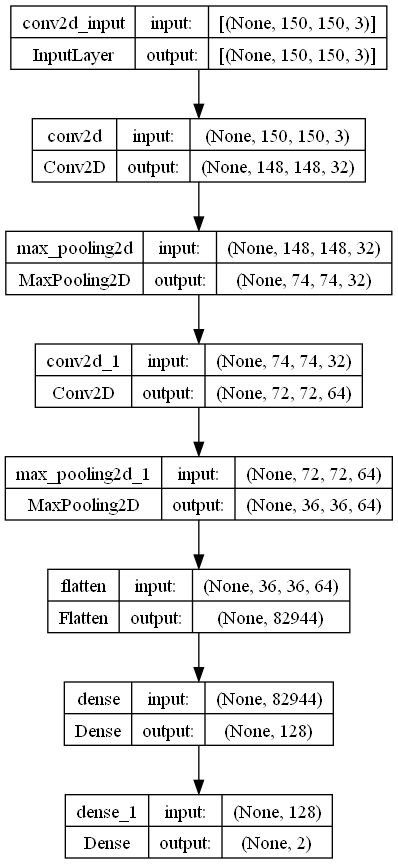

In [4]:
from tensorflow.keras.utils import plot_model

# Assuming your model is defined and named "model"
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [16]:
from tensorflow.keras.layers import Input

visible1 = Input(shape=(150, 150, 3))
visible2 = Input(shape=(150, 150, 3))

# Architecture for visible1
x1 = Conv2D(32, (3, 3), activation='relu')(visible1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)
x1 = Conv2D(64, (3, 3), activation='relu')(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)
x1 = Flatten()(x1)
x1 = Dense(128, activation='relu')(x1)

# Architecture for visible2
x2 = Conv2D(32, (3, 3), activation='relu')(visible2)
x2 = MaxPooling2D(pool_size=(2, 2))(x2)
x2 = Conv2D(64, (3, 3), activation='relu')(x2)
x2 = MaxPooling2D(pool_size=(2, 2))(x2)
x2 = Flatten()(x2)
x2 = Dense(128, activation='relu')(x2)

from tensorflow.keras.layers import concatenate

merged = concatenate([x1, x2])
output = Dense(len(train_generator.class_indices), activation='softmax')(merged)


from tensorflow.keras.models import Model

model = Model(inputs=[visible1, visible2], outputs=output)


In [19]:

# merge input models
merge = concatenate([dense1, dense2])
output = Dense(1)(merge)

NameError: name 'dense1' is not defined

In [23]:
"""
Weapon detection in video
"""

def predict_weapon_video(video_path):
    # Open the video file
    video = cv2.VideoCapture(video_path)

    while(video.isOpened()):
        # Read a frame
        ret, frame = video.read()
        if not ret:
            break

        # Convert the frame color
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Resize the frame to the size your model expects
        resized_frame = cv2.resize(frame_rgb, (150, 150))

        # Normalize the frame
        normalized_frame = resized_frame / 255.0

        # Expand dimensions to match the shape the model expects
        frame_expanded = np.expand_dims(normalized_frame, axis=0)

        # Use the model to predict the weapon
        prediction = model.predict(frame_expanded)
        label = np.argmax(prediction)

        # Get the label name from the train generator's class_indices
        label_name = list(train_generator.class_indices.keys())[
            list(train_generator.class_indices.values()).index(label)]

        print(f"Label: {label_name} - Prediction: {prediction}")
        # Add a label to the frame
        cv2.putText(frame, label_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        # Display the frame
        cv2.imshow('Video', frame)

        # Break the loop on 'q' press
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # When everything is done, release the video capture and video write objects
    video.release()

    # Close all the frames
    cv2.destroyAllWindows()

# predict_weapon_video('C:/Users/mupaj/Documents/Apps/final_vc/data/pexels'
#                    '-karolina-grabowska-5243196-1920x1080-25fps.mp4')

# predict_weapon_video('C:/Users/mupaj/Documents/Apps/final_vc/data/pexels-erica-hotaru-5933320-1920x1080-50fps.mp4')
predict_weapon_video('C:/Users/mupaj/Documents/Apps/final_vc/data/180925_02_01_preview.mp4')


1/1 [==============================] - 0s 62ms/step
Label: knife - Prediction: [[0.91997945 0.08002057]]
1/1 [==============================] - 0s 29ms/step
Label: knife - Prediction: [[0.93156785 0.0684322 ]]
1/1 [==============================] - 0s 27ms/step
Label: knife - Prediction: [[0.99625945 0.00374055]]
1/1 [==============================] - 0s 33ms/step
Label: pistol - Prediction: [[0.18999398 0.810006  ]]
1/1 [==============================] - 0s 30ms/step
Label: knife - Prediction: [[0.8732139  0.12678604]]
1/1 [==============================] - 0s 28ms/step
Label: pistol - Prediction: [[5.0757435e-06 9.9999487e-01]]
1/1 [==============================] - 0s 31ms/step
Label: knife - Prediction: [[0.667418 0.332582]]
1/1 [==============================] - 0s 28ms/step
Label: pistol - Prediction: [[1.5498856e-11 1.0000000e+00]]
1/1 [==============================] - 0s 24ms/step
Label: pistol - Prediction: [[1.880992e-12 1.000000e+00]]
1/1 [==============================] - 

KeyboardInterrupt: 